# Credit Card Fraud Detection - Data Loading & Understanding

## Overview

This notebook establishes the foundation for credit card fraud detection analysis by implementing memory-optimized data loading, comprehensive data quality assessment, and initial understanding of the dataset characteristics. The analysis focuses on a synthetic credit card transaction dataset with ~1.3M training records and severe class imbalance (172:1 fraud ratio), requiring specialized handling techniques throughout the analysis pipeline.


## Table of Contents

1. [Environment Setup & Validation](#1-environment-setup--validation)
2. [Data Loading Infrastructure](#2-data-loading-infrastructure)
3. [Data Understanding & Structure Analysis](#3-data-understanding--structure-analysis)
4. [Data Quality Assessment](#4-data-quality-assessment)
5. [Class Distribution Analysis](#5-class-distribution-analysis)
6. [Initial Data Understanding](#6-initial-data-understanding)
7. [Key Findings & Next Steps](#7-key-findings--next-steps)

---

## 1. Environment Setup & Validation

This section validates the development environment, verifies all required dependencies, and establishes the foundation for reliable data processing.

In [1]:
# Core Libraries for Data Processing
import pandas as pd
import numpy as np
import warnings
import sys
import os
from pathlib import Path
import psutil
import gc
from datetime import datetime
import time

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical Analysis
from scipy import stats
from scipy.stats import chi2_contingency, kstest

# Utility Libraries
from tqdm.auto import tqdm
import joblib

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plotting Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("All libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Python version: {sys.version}")

All libraries imported successfully
Pandas version: 2.3.1
NumPy version: 2.2.6
Python version: 3.13.5 (main, Jun 11 2025, 15:36:57) [Clang 17.0.0 (clang-1700.0.13.3)]


### System Resource Assessment

Evaluate available system resources to optimize data processing strategy.

In [2]:
# System Resource Assessment
def assess_system_resources():
    """
    Assess available system resources for optimized processing.
    
    Returns:
        dict: System resource information
    """
    memory_info = psutil.virtual_memory()
    disk_info = psutil.disk_usage('/')
    cpu_count = psutil.cpu_count()
    
    resources = {
        'total_memory_gb': round(memory_info.total / (1024**3), 2),
        'available_memory_gb': round(memory_info.available / (1024**3), 2),
        'memory_usage_percent': memory_info.percent,
        'disk_free_gb': round(disk_info.free / (1024**3), 2),
        'cpu_cores': cpu_count,
        'logical_processors': psutil.cpu_count(logical=True)
    }
    
    return resources

# Assess current resources
system_resources = assess_system_resources()

print("System Resource Assessment")
print("=" * 40)
print(f"Total Memory: {system_resources['total_memory_gb']} GB")
print(f"Available Memory: {system_resources['available_memory_gb']} GB")
print(f"Memory Usage: {system_resources['memory_usage_percent']}%")
print(f"Available Disk Space: {system_resources['disk_free_gb']} GB")
print(f"CPU Cores: {system_resources['cpu_cores']}")
print(f"Logical Processors: {system_resources['logical_processors']}")

# Memory optimization recommendations
if system_resources['available_memory_gb'] < 8:
    print("\nWARNING: Available memory < 8GB. Consider chunked processing.")
elif system_resources['available_memory_gb'] < 12:
    print("\nCAUTION: Available memory < 12GB. Memory optimization recommended.")
else:
    print("\nSufficient memory available for standard processing.")

System Resource Assessment
Total Memory: 16.0 GB
Available Memory: 2.89 GB
Memory Usage: 81.9%
Available Disk Space: 84.08 GB
CPU Cores: 8
Logical Processors: 8



### Environment Validation

Verify all required dependencies are installed and functioning correctly.

In [3]:
# Environment Validation
def validate_environment():
    """
    Validate all required libraries and their versions.
    
    Returns:
        dict: Validation results
    """
    validation_results = {
        'python_version': sys.version_info >= (3, 9),
        'pandas_available': True,
        'numpy_available': True,
        'matplotlib_available': True,
        'seaborn_available': True,
        'plotly_available': True,
        'scipy_available': True,
        'tqdm_available': True,
        'joblib_available': True
    }
    
    try:
        # Test basic operations
        test_df = pd.DataFrame({'test': [1, 2, 3]})
        test_array = np.array([1, 2, 3])
        
        # Test visualization
        fig, ax = plt.subplots(figsize=(1, 1))
        plt.close(fig)
        
        validation_results['basic_operations'] = True
        validation_results['visualization'] = True
        
    except Exception as e:
        validation_results['basic_operations'] = False
        validation_results['error'] = str(e)
    
    return validation_results

# Run validation
validation = validate_environment()

print("Environment Validation Results")
print("=" * 40)

for component, status in validation.items():
    if component != 'error':
        status_text = "PASS" if status else "FAIL"
        print(f"{component.replace('_', ' ').title()}: {status_text}")

if all(v for k, v in validation.items() if k != 'error'):
    print("\nAll environment validations passed!")
else:
    print("\nSome validations failed. Please check your environment.")

Environment Validation Results
Python Version: PASS
Pandas Available: PASS
Numpy Available: PASS
Matplotlib Available: PASS
Seaborn Available: PASS
Plotly Available: PASS
Scipy Available: PASS
Tqdm Available: PASS
Joblib Available: PASS
Basic Operations: PASS
Visualization: PASS

All environment validations passed!


---

## 2. Data Loading Infrastructure

Implementation of memory-optimized data loading with performance monitoring and robust error handling.

### Data Path Configuration

Configure paths and validate dataset availability.

In [4]:
# Data Path Configuration
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebook' else Path.cwd()
DATA_PATH = PROJECT_ROOT / 'Data'
TRAIN_FILE = DATA_PATH / 'fraudTrain.csv'
TEST_FILE = DATA_PATH / 'fraudTest.csv'

print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Path: {DATA_PATH}")
print(f"Training File: {TRAIN_FILE}")
print(f"Test File: {TEST_FILE}")

# Validate file existence
print("\nFile Availability Check:")
print(f"Training file exists: {TRAIN_FILE.exists()}")
print(f"Test file exists: {TEST_FILE.exists()}")

if TRAIN_FILE.exists() and TEST_FILE.exists():
    # Get file sizes
    train_size_mb = TRAIN_FILE.stat().st_size / (1024**2)
    test_size_mb = TEST_FILE.stat().st_size / (1024**2)
    
    print(f"\nFile Sizes:")
    print(f"Training file: {train_size_mb:.1f} MB")
    print(f"Test file: {test_size_mb:.1f} MB")
    print(f"Total size: {train_size_mb + test_size_mb:.1f} MB")
else:
    print("\nDataset files not found. Please check data directory.")

Project Root: /Users/ms/Downloads/PROJECT PORTOFOLIO PERSONAL/Credit Card Fraud Detection
Data Path: /Users/ms/Downloads/PROJECT PORTOFOLIO PERSONAL/Credit Card Fraud Detection/Data
Training File: /Users/ms/Downloads/PROJECT PORTOFOLIO PERSONAL/Credit Card Fraud Detection/Data/fraudTrain.csv
Test File: /Users/ms/Downloads/PROJECT PORTOFOLIO PERSONAL/Credit Card Fraud Detection/Data/fraudTest.csv

File Availability Check:
Training file exists: True
Test file exists: True

File Sizes:
Training file: 335.0 MB
Test file: 143.4 MB
Total size: 478.4 MB


### Memory-Optimized Data Loading

Implement strategic data type optimization and performance monitoring for efficient data loading.

In [5]:
def get_optimized_dtypes():
    """
    Define optimized data types for memory efficiency.
    
    Returns:
        dict: Column name to dtype mapping
    """
    return {
        # Transaction identifiers - keep as object for now
        'trans_date_trans_time': 'object',
        'cc_num': 'object',
        'trans_num': 'object',
        
        # Merchant information
        'merchant': 'category',
        'category': 'category',
        
        # Transaction amount - float32 sufficient for amounts
        'amt': 'float32',
        
        # Personal information
        'first': 'category',
        'last': 'category', 
        'gender': 'category',
        'street': 'object',  # High cardinality, keep as object
        'city': 'category',
        'state': 'category',
        'zip': 'object',  # ZIP codes better as object
        'job': 'category',
        'dob': 'object',  # Date of birth
        
        # Geographic coordinates - float32 sufficient
        'lat': 'float32',
        'long': 'float32',
        'city_pop': 'int32',  # City population
        'merch_lat': 'float32',
        'merch_long': 'float32',
        
        # Unix timestamp - int64 required
        'unix_time': 'int64',
        
        # Target variable - boolean for efficiency
        'is_fraud': 'bool'
    }

def load_data_optimized(filepath, sample_size=None, optimize_dtypes=True):
    """
    Load data with memory optimization and performance monitoring.
    
    Parameters:
        filepath (Path): Path to CSV file
        sample_size (int): Number of rows to sample (None for all)
        optimize_dtypes (bool): Whether to apply dtype optimization
    
    Returns:
        tuple: (DataFrame, loading_stats)
    """
    print(f"Loading data from: {filepath.name}")
    
    # Record start time and memory
    start_time = time.time()
    start_memory = psutil.virtual_memory().used / (1024**3)
    
    try:
        # Get optimized dtypes if requested
        dtypes = get_optimized_dtypes() if optimize_dtypes else None
        
        # Load data with progress bar
        if sample_size:
            print(f"Loading sample of {sample_size:,} rows...")
            df = pd.read_csv(filepath, dtype=dtypes, nrows=sample_size)
        else:
            print(f"Loading complete dataset...")
            df = pd.read_csv(filepath, dtype=dtypes)
        
        # Record end time and memory
        end_time = time.time()
        end_memory = psutil.virtual_memory().used / (1024**3)
        
        # Calculate statistics
        loading_stats = {
            'loading_time_seconds': round(end_time - start_time, 2),
            'memory_used_gb': round(end_memory - start_memory, 2),
            'dataset_memory_mb': round(df.memory_usage(deep=True).sum() / (1024**2), 2),
            'rows_loaded': len(df),
            'columns_loaded': len(df.columns),
            'dtype_optimized': optimize_dtypes
        }
        
        print(f"Data loaded successfully!")
        print(f"Loading time: {loading_stats['loading_time_seconds']} seconds")
        print(f"Memory used: {loading_stats['memory_used_gb']} GB")
        print(f"Dataset size: {loading_stats['dataset_memory_mb']} MB")
        print(f"Shape: {df.shape}")
        
        return df, loading_stats
        
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise e

# Load training dataset
print("Loading Training Dataset")
print("=" * 50)
train_df, train_loading_stats = load_data_optimized(TRAIN_FILE)

print("\n" + "=" * 50)
print("Loading Performance Summary")
print("=" * 50)
for key, value in train_loading_stats.items():
    print(f"{key.replace('_', ' ').title()}: {value}")

Loading Training Dataset
Loading data from: fraudTrain.csv
Loading complete dataset...
Data loaded successfully!
Loading time: 2.57 seconds
Memory used: -0.39 GB
Dataset size: 558.68 MB
Shape: (1296675, 23)

Loading Performance Summary
Loading Time Seconds: 2.57
Memory Used Gb: -0.39
Dataset Memory Mb: 558.68
Rows Loaded: 1296675
Columns Loaded: 23
Dtype Optimized: True


### Data Type Optimization Analysis

Compare memory usage before and after optimization to validate efficiency gains.

In [6]:
# Compare optimized vs unoptimized loading
def compare_loading_efficiency(filepath, sample_size=10000):
    """
    Compare memory efficiency between optimized and unoptimized loading.
    
    Parameters:
        filepath (Path): Path to CSV file
        sample_size (int): Sample size for comparison
    
    Returns:
        dict: Comparison results
    """
    print(f"Memory Efficiency Comparison (Sample: {sample_size:,} rows)")
    print("=" * 60)
    
    # Load without optimization
    print("Loading without optimization...")
    df_unopt, stats_unopt = load_data_optimized(filepath, sample_size, optimize_dtypes=False)
    
    print("\nLoading with optimization...")
    df_opt, stats_opt = load_data_optimized(filepath, sample_size, optimize_dtypes=True)
    
    # Calculate savings
    memory_savings_mb = stats_unopt['dataset_memory_mb'] - stats_opt['dataset_memory_mb']
    memory_savings_percent = (memory_savings_mb / stats_unopt['dataset_memory_mb']) * 100
    time_difference = stats_opt['loading_time_seconds'] - stats_unopt['loading_time_seconds']
    
    comparison = {
        'unoptimized_memory_mb': stats_unopt['dataset_memory_mb'],
        'optimized_memory_mb': stats_opt['dataset_memory_mb'],
        'memory_savings_mb': round(memory_savings_mb, 2),
        'memory_savings_percent': round(memory_savings_percent, 1),
        'unoptimized_time_s': stats_unopt['loading_time_seconds'],
        'optimized_time_s': stats_opt['loading_time_seconds'],
        'time_difference_s': round(time_difference, 2)
    }
    
    print("\nOptimization Results:")
    print(f"Memory saved: {comparison['memory_savings_mb']} MB ({comparison['memory_savings_percent']}%)")
    print(f"Time difference: {comparison['time_difference_s']} seconds")
    
    # Cleanup
    del df_unopt, df_opt
    gc.collect()
    
    return comparison

# Run comparison
optimization_comparison = compare_loading_efficiency(TRAIN_FILE, sample_size=10000)

Memory Efficiency Comparison (Sample: 10,000 rows)
Loading without optimization...
Loading data from: fraudTrain.csv
Loading sample of 10,000 rows...
Data loaded successfully!
Loading time: 0.03 seconds
Memory used: 0.0 GB
Dataset size: 7.98 MB
Shape: (10000, 23)

Loading with optimization...
Loading data from: fraudTrain.csv
Loading sample of 10,000 rows...
Data loaded successfully!
Loading time: 0.03 seconds
Memory used: 0.0 GB
Dataset size: 4.57 MB
Shape: (10000, 23)

Optimization Results:
Memory saved: 3.41 MB (42.7%)
Time difference: 0.0 seconds


---

## 3. Data Understanding & Structure Analysis

Comprehensive analysis of dataset structure, features, and basic characteristics.

### Dataset Overview

examination of dataset structure and basic properties.

In [7]:
def analyze_dataset_structure(df, dataset_name="Dataset"):
    """
    Analyze basic dataset structure and properties.
    
    Parameters:
        df (DataFrame): Dataset to analyze
        dataset_name (str): Name for display
    
    Returns:
        dict: Structure analysis results
    """
    print(f"{dataset_name} Structure Analysis")
    print("=" * 50)
    
    # Basic structure
    print(f"Shape: {df.shape}")
    print(f"Rows: {df.shape[0]:,}")
    print(f"Columns: {df.shape[1]:,}")
    print(f"Memory Usage: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
    
    # Data types analysis
    dtype_counts = df.dtypes.value_counts()
    print(f"\nData Types Distribution:")
    for dtype, count in dtype_counts.items():
        print(f"   {dtype}: {count} columns")
    
    # Column names
    print(f"\nColumn Names:")
    for i, col in enumerate(df.columns, 1):
        print(f"   {i:2d}. {col}")
    
    structure_info = {
        'shape': df.shape,
        'memory_mb': df.memory_usage(deep=True).sum() / (1024**2),
        'dtypes': dict(dtype_counts),
        'columns': list(df.columns)
    }
    
    return structure_info

# Analyze training dataset structure
train_structure = analyze_dataset_structure(train_df, "Training Dataset")

Training Dataset Structure Analysis
Shape: (1296675, 23)
Rows: 1,296,675
Columns: 23
Memory Usage: 558.68 MB

Data Types Distribution:
   object: 6 columns
   float32: 5 columns
   int64: 2 columns
   category: 1 columns
   category: 1 columns
   category: 1 columns
   category: 1 columns
   category: 1 columns
   category: 1 columns
   category: 1 columns
   int32: 1 columns
   category: 1 columns
   bool: 1 columns

Column Names:
    1. Unnamed: 0
    2. trans_date_trans_time
    3. cc_num
    4. merchant
    5. category
    6. amt
    7. first
    8. last
    9. gender
   10. street
   11. city
   12. state
   13. zip
   14. lat
   15. long
   16. city_pop
   17. job
   18. dob
   19. trans_num
   20. unix_time
   21. merch_lat
   22. merch_long
   23. is_fraud


### Feature Documentation & Business Context


In [8]:
def create_feature_dictionary(df):
    """
    Create comprehensive feature documentation with business context.
    
    Parameters:
        df (DataFrame): Dataset to document
    
    Returns:
        dict: Feature documentation
    """
    feature_dict = {
        'trans_date_trans_time': {
            'description': 'Transaction timestamp',
            'type': 'Temporal',
            'business_meaning': 'When the transaction occurred - critical for temporal fraud patterns',
            'fraud_relevance': 'High - fraud often occurs at unusual times'
        },
        'cc_num': {
            'description': 'Credit card number (anonymized)',
            'type': 'Identifier', 
            'business_meaning': 'Unique credit card identifier for tracking card-specific patterns',
            'fraud_relevance': 'High - card compromise patterns'
        },
        'merchant': {
            'description': 'Merchant name where transaction occurred',
            'type': 'Categorical',
            'business_meaning': 'Business establishment - merchant fraud patterns',
            'fraud_relevance': 'Medium - some merchants may be higher risk'
        },
        'category': {
            'description': 'Transaction category/type',
            'type': 'Categorical',
            'business_meaning': 'Type of purchase - different categories have different fraud rates',
            'fraud_relevance': 'High - category-specific fraud patterns'
        },
        'amt': {
            'description': 'Transaction amount in USD',
            'type': 'Numerical',
            'business_meaning': 'Financial value - critical fraud indicator',
            'fraud_relevance': 'Very High - amount anomalies indicate fraud'
        },
        'first': {
            'description': 'Customer first name',
            'type': 'Categorical',
            'business_meaning': 'Customer identification component',
            'fraud_relevance': 'Low - mainly for customer identification'
        },
        'last': {
            'description': 'Customer last name',
            'type': 'Categorical',
            'business_meaning': 'Customer identification component',
            'fraud_relevance': 'Low - mainly for customer identification'
        },
        'gender': {
            'description': 'Customer gender',
            'type': 'Categorical',
            'business_meaning': 'Demographic segmentation for pattern analysis',
            'fraud_relevance': 'Low-Medium - demographic fraud patterns'
        },
        'street': {
            'description': 'Customer street address',
            'type': 'Categorical',
            'business_meaning': 'Customer location - high cardinality',
            'fraud_relevance': 'Low - too granular for patterns'
        },
        'city': {
            'description': 'Customer city',
            'type': 'Categorical',
            'business_meaning': 'Customer location for geographic analysis',
            'fraud_relevance': 'Medium - city-level fraud patterns'
        },
        'state': {
            'description': 'Customer state',
            'type': 'Categorical',
            'business_meaning': 'Customer location for regional analysis',
            'fraud_relevance': 'Medium - state-level fraud patterns'
        },
        'zip': {
            'description': 'Customer ZIP code',
            'type': 'Categorical',
            'business_meaning': 'Customer location - socioeconomic indicator',
            'fraud_relevance': 'Medium - ZIP-level risk profiling'
        },
        'lat': {
            'description': 'Customer latitude coordinate',
            'type': 'Numerical',
            'business_meaning': 'Precise customer location for distance calculations',
            'fraud_relevance': 'High - enables distance-based features'
        },
        'long': {
            'description': 'Customer longitude coordinate',
            'type': 'Numerical',
            'business_meaning': 'Precise customer location for distance calculations',
            'fraud_relevance': 'High - enables distance-based features'
        },
        'city_pop': {
            'description': 'Population of customer city',
            'type': 'Numerical',
            'business_meaning': 'Urban vs rural classification, socioeconomic context',
            'fraud_relevance': 'Medium - urban/rural fraud differences'
        },
        'job': {
            'description': 'Customer occupation',
            'type': 'Categorical',
            'business_meaning': 'Professional/income level indicator',
            'fraud_relevance': 'Medium - occupation-based risk profiling'
        },
        'dob': {
            'description': 'Customer date of birth',
            'type': 'Temporal',
            'business_meaning': 'Age calculation for demographic analysis',
            'fraud_relevance': 'Medium - age-based fraud patterns'
        },
        'trans_num': {
            'description': 'Unique transaction identifier',
            'type': 'Identifier',
            'business_meaning': 'Transaction tracking and audit trail',
            'fraud_relevance': 'Low - mainly for data management'
        },
        'unix_time': {
            'description': 'Transaction timestamp in Unix format',
            'type': 'Temporal',
            'business_meaning': 'Precise timing for temporal analysis',
            'fraud_relevance': 'High - enables time-based feature engineering'
        },
        'merch_lat': {
            'description': 'Merchant latitude coordinate',
            'type': 'Numerical',
            'business_meaning': 'Merchant location for distance calculations',
            'fraud_relevance': 'High - customer-merchant distance features'
        },
        'merch_long': {
            'description': 'Merchant longitude coordinate',
            'type': 'Numerical',
            'business_meaning': 'Merchant location for distance calculations',
            'fraud_relevance': 'High - customer-merchant distance features'
        },
        'is_fraud': {
            'description': 'Fraud indicator (target variable)',
            'type': 'Boolean',
            'business_meaning': 'Ground truth for fraud detection modeling',
            'fraud_relevance': 'Target Variable - what we predict'
        }
    }
    
    return feature_dict

# Create feature dictionary
feature_dictionary = create_feature_dictionary(train_df)

# Display feature documentation
print("Feature Dictionary & Business Context")
print("=" * 70)

for feature, info in feature_dictionary.items():
    if feature in train_df.columns:
        print(f"\n{feature}")
        print(f"   Description: {info['description']}")
        print(f"   Type: {info['type']}")
        print(f"   Business Meaning: {info['business_meaning']}")
        print(f"   Fraud Relevance: {info['fraud_relevance']}")

Feature Dictionary & Business Context

trans_date_trans_time
   Description: Transaction timestamp
   Type: Temporal
   Business Meaning: When the transaction occurred - critical for temporal fraud patterns
   Fraud Relevance: High - fraud often occurs at unusual times

cc_num
   Description: Credit card number (anonymized)
   Type: Identifier
   Business Meaning: Unique credit card identifier for tracking card-specific patterns
   Fraud Relevance: High - card compromise patterns

merchant
   Description: Merchant name where transaction occurred
   Type: Categorical
   Business Meaning: Business establishment - merchant fraud patterns
   Fraud Relevance: Medium - some merchants may be higher risk

category
   Description: Transaction category/type
   Type: Categorical
   Business Meaning: Type of purchase - different categories have different fraud rates
   Fraud Relevance: High - category-specific fraud patterns

amt
   Description: Transaction amount in USD
   Type: Numerical
   Busi

### Basic Statistical Summary

Descriptive statistics for all features to understand data distributions and ranges.

In [9]:
# Comprehensive statistical summary
def generate_statistical_summary(df):
    """
    Generate comprehensive statistical summary for all feature types.
    
    Parameters:
        df (DataFrame): Dataset to analyze
    
    Returns:
        dict: Statistical summaries by feature type
    """
    print("Comprehensive Statistical Summary")
    print("=" * 50)
    
    # Separate features by type
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()
    
    # Remove target from categorical if it's boolean
    if 'is_fraud' in categorical_features and df['is_fraud'].dtype == 'bool':
        categorical_features.remove('is_fraud')
    
    summaries = {}
    
    # Numerical features summary
    if numerical_features:
        print("\nNumerical Features Summary:")
        numerical_summary = df[numerical_features].describe()
        print(numerical_summary)
        summaries['numerical'] = numerical_summary
        
        # Additional statistics for numerical features
        print("\nAdditional Numerical Statistics:")
        for feature in numerical_features:
            skewness = df[feature].skew()
            kurtosis = df[feature].kurtosis()
            print(f"   {feature:15s} - Skewness: {skewness:6.3f}, Kurtosis: {kurtosis:6.3f}")
    
    # Categorical features summary
    if categorical_features:
        print("\nCategorical Features Summary:")
        categorical_summary = {}
        
        for feature in categorical_features:
            unique_count = df[feature].nunique()
            most_common = df[feature].mode().iloc[0] if len(df[feature].mode()) > 0 else 'N/A'
            most_common_freq = df[feature].value_counts().iloc[0] if len(df[feature].value_counts()) > 0 else 0
            
            categorical_summary[feature] = {
                'unique_values': unique_count,
                'most_common': most_common,
                'most_common_frequency': most_common_freq,
                'cardinality': 'High' if unique_count > 100 else 'Medium' if unique_count > 10 else 'Low'
            }
            
            print(f"   {feature:20s} - Unique: {unique_count:5d}, Cardinality: {categorical_summary[feature]['cardinality']:6s}, Most Common: {str(most_common)[:20]}")
        
        summaries['categorical'] = categorical_summary
    
    # Target variable summary (if present)
    if 'is_fraud' in df.columns:
        print("\nTarget Variable Summary:")
        fraud_counts = df['is_fraud'].value_counts()
        fraud_percentages = df['is_fraud'].value_counts(normalize=True) * 100
        
        print(f"   Legitimate transactions: {fraud_counts[False]:,} ({fraud_percentages[False]:.3f}%)")
        print(f"   Fraudulent transactions: {fraud_counts[True]:,} ({fraud_percentages[True]:.3f}%)")
        print(f"   Fraud ratio: 1:{fraud_counts[False]/fraud_counts[True]:.0f}")
        
        summaries['target'] = {
            'legitimate_count': fraud_counts[False],
            'fraud_count': fraud_counts[True],
            'fraud_percentage': fraud_percentages[True],
            'fraud_ratio': fraud_counts[False]/fraud_counts[True]
        }
    
    return summaries

# Generate statistical summary
statistical_summary = generate_statistical_summary(train_df)

Comprehensive Statistical Summary

Numerical Features Summary:
        Unnamed: 0          amt          lat         long     city_pop  \
count 1296675.0000 1296675.0000 1296675.0000 1296675.0000 1296675.0000   
mean   648337.0000      70.3510      38.5376     -90.2264   88824.4406   
std    374317.9745     160.3160       5.0758      13.7591  301956.3607   
min         0.0000       1.0000      20.0271    -165.6723      23.0000   
25%    324168.5000       9.6500      34.6205     -96.7980     743.0000   
50%    648337.0000      47.5200      39.3543     -87.4769    2456.0000   
75%    972505.5000      83.1400      41.9404     -80.1580   20328.0000   
max   1296674.0000   28948.9004      66.6933     -67.9503 2906700.0000   

            unix_time    merch_lat   merch_long  
count    1296675.0000 1296675.0000 1296675.0000  
mean  1349243636.7261      38.5373     -90.2264  
std     12841278.4234       5.1098      13.7711  
min   1325376018.0000      19.0278    -166.6712  
25%   1338750742.500

### Sample Data Inspection

Examine representative samples to understand data format and quality.

In [10]:
# Sample data inspection
print("Sample Data Inspection")
print("=" * 50)

print("\nFirst 5 rows:")
display(train_df.head())

print("\nRandom 5 rows:")
display(train_df.sample(5, random_state=42))

# Sample fraud and legitimate transactions
if 'is_fraud' in train_df.columns:
    fraud_samples = train_df[train_df['is_fraud'] == True].head(3)
    legit_samples = train_df[train_df['is_fraud'] == False].head(3)
    
    print("\nSample Fraudulent Transactions:")
    display(fraud_samples[['trans_date_trans_time', 'amt', 'category', 'merchant', 'is_fraud']])
    
    print("\nSample Legitimate Transactions:")
    display(legit_samples[['trans_date_trans_time', 'amt', 'category', 'merchant', 'is_fraud']])

# Data format analysis
print("\nData Format Analysis:")
for col in train_df.columns[:10]:  # First 10 columns
    sample_values = train_df[col].dropna().head(3).tolist()
    print(f"   {col:20s}: {sample_values}")

Sample Data Inspection

First 5 rows:


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.9700,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.0113,-82.0483,False
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.2300,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.1590,-118.1865,False
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.1100,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.1507,-112.1545,False
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.0000,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.0343,-112.5611,False
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.9600,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.6750,-78.6325,False



Random 5 rows:


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
1045211,1045211,2020-03-09 15:09:26,577588686219,fraud_Towne LLC,misc_pos,194.5100,James,Strickland,M,25454 Leonard Lake,Spring Church,PA,15686,40.6153,-79.4545,972,Public relations account executive,1997-10-23,fff87d4340ef756a592eac652493cf6b,1362841766,40.4205,-78.8650,False
547406,547406,2019-08-22 15:49:01,30376238035123,fraud_Friesen Ltd,health_fitness,52.3200,Cynthia,Davis,F,7177 Steven Forges,Sixes,OR,97476,42.8250,-124.4409,217,Retail merchandiser,1928-10-01,d0ad335af432f35578eea01d639b3621,1345650541,42.7589,-123.6363,False
110142,110142,2019-03-04 01:34:16,4658490815480264,fraud_Mohr Inc,shopping_pos,6.5300,Tara,Richards,F,4879 Cristina Station,Keisterville,PA,15449,39.9636,-79.7853,184,Systems developer,1945-11-04,87f26e3ea33f4ff4c7a8bad2c7f48686,1330824856,40.4752,-78.8982,False
1285953,1285953,2020-06-16 20:04:38,3514897282719543,fraud_Gaylord-Powlowski,home,7.3300,Steven,Faulkner,M,841 Cheryl Centers Suite 115,Farmington,NY,14425,42.9580,-77.3083,10717,Cytogeneticist,1952-10-13,9c34015321c0fa2ae6fd20f9359d1d3e,1371413078,43.7675,-76.5424,False
271705,271705,2019-05-14 05:54:48,6011381817520024,"fraud_Christiansen, Goyette and Schamberger",gas_transport,64.2900,Kristen,Allen,F,8619 Lisa Manors Apt. 871,Lagrange,WY,82221,41.6423,-104.1974,635,Product/process development scientist,1973-07-13,198437c05676f485e9be04449c664475,1336974888,41.0404,-104.0923,False



Sample Fraudulent Transactions:


,trans_date_trans_time,amt,category,merchant,is_fraud
2449,2019-01-02 01:06:37,281.0600,grocery_pos,fraud_Rutherford-Mertz,True
2472,2019-01-02 01:47:29,11.5200,gas_transport,"fraud_Jenkins, Hauck and Friesen",True
2523,2019-01-02 03:05:23,276.3100,grocery_pos,fraud_Goodwin-Nitzsche,True



Sample Legitimate Transactions:


,trans_date_trans_time,amt,category,merchant,is_fraud
0,2019-01-01 00:00:18,4.9700,misc_net,"fraud_Rippin, Kub and Mann",False
1,2019-01-01 00:00:44,107.2300,grocery_pos,"fraud_Heller, Gutmann and Zieme",False
2,2019-01-01 00:00:51,220.1100,entertainment,fraud_Lind-Buckridge,False



Data Format Analysis:
   Unnamed: 0          : [0, 1, 2]
   trans_date_trans_time: ['2019-01-01 00:00:18', '2019-01-01 00:00:44', '2019-01-01 00:00:51']
   cc_num              : ['2703186189652095', '630423337322', '38859492057661']
   merchant            : ['fraud_Rippin, Kub and Mann', 'fraud_Heller, Gutmann and Zieme', 'fraud_Lind-Buckridge']
   category            : ['misc_net', 'grocery_pos', 'entertainment']
   amt                 : [4.96999979019165, 107.2300033569336, 220.11000061035156]
   first               : ['Jennifer', 'Stephanie', 'Edward']
   last                : ['Banks', 'Gill', 'Sanchez']
   gender              : ['F', 'F', 'M']
   street              : ['561 Perry Cove', '43039 Riley Greens Suite 393', '594 White Dale Suite 530']


---

## 4. Data Quality Assessment

Comprehensive analysis of data quality including missing values, outliers, and consistency checks.

### Missing Value Analysis

Systematic identification and analysis of missing data patterns.

In [11]:
def analyze_missing_values(df, dataset_name="Dataset"):
    """
    Comprehensive missing value analysis.
    
    Parameters:
        df (DataFrame): Dataset to analyze
        dataset_name (str): Name for display
    
    Returns:
        dict: Missing value analysis results
    """
    print(f"{dataset_name} - Missing Value Analysis")
    print("=" * 60)
    
    # Calculate missing values
    missing_counts = df.isnull().sum()
    missing_percentages = (missing_counts / len(df)) * 100
    
    # Create missing value summary
    missing_summary = pd.DataFrame({
        'Missing_Count': missing_counts,
        'Missing_Percentage': missing_percentages,
        'Data_Type': df.dtypes
    }).sort_values('Missing_Count', ascending=False)
    
    # Display results
    if missing_summary['Missing_Count'].sum() == 0:
        print("No missing values found in the dataset!")
        return {'has_missing': False, 'summary': missing_summary}
    else:
        print(f"Found missing values in {(missing_summary['Missing_Count'] > 0).sum()} columns:")
        print("\nMissing Value Summary:")
        display(missing_summary[missing_summary['Missing_Count'] > 0])
        
        # Missing value patterns
        total_missing = missing_summary['Missing_Count'].sum()
        total_cells = len(df) * len(df.columns)
        overall_missing_rate = (total_missing / total_cells) * 100
        
        print(f"\nOverall Missing Data Statistics:")
        print(f"   Total missing values: {total_missing:,}")
        print(f"   Overall missing rate: {overall_missing_rate:.4f}%")
        print(f"   Columns with missing data: {(missing_summary['Missing_Count'] > 0).sum()}")
        
        return {
            'has_missing': True, 
            'summary': missing_summary,
            'total_missing': total_missing,
            'overall_missing_rate': overall_missing_rate
        }

# Analyze missing values
missing_analysis = analyze_missing_values(train_df, "Training Dataset")

Training Dataset - Missing Value Analysis
No missing values found in the dataset!


### Data Consistency & Range Validation

Validate data consistency and check for values outside expected business ranges.

In [12]:
def validate_data_consistency(df):
    """
    Validate data consistency and business logic.
    
    Parameters:
        df (DataFrame): Dataset to validate
    
    Returns:
        dict: Validation results
    """
    print("Data Consistency & Range Validation")
    print("=" * 50)
    
    validation_results = {}
    
    # Transaction amount validation
    if 'amt' in df.columns:
        amt_issues = {
            'negative_amounts': (df['amt'] < 0).sum(),
            'zero_amounts': (df['amt'] == 0).sum(),
            'extremely_high_amounts': (df['amt'] > 10000).sum(),
            'min_amount': df['amt'].min(),
            'max_amount': df['amt'].max()
        }
        validation_results['amount_validation'] = amt_issues
        
        print("Transaction Amount Validation:")
        print(f"   Negative amounts: {amt_issues['negative_amounts']:,}")
        print(f"   Zero amounts: {amt_issues['zero_amounts']:,}")
        print(f"   Extremely high amounts (>$10,000): {amt_issues['extremely_high_amounts']:,}")
        print(f"   Amount range: ${amt_issues['min_amount']:,.2f} - ${amt_issues['max_amount']:,.2f}")
    
    # Geographic coordinate validation
    if all(col in df.columns for col in ['lat', 'long', 'merch_lat', 'merch_long']):
        geo_issues = {
            'invalid_customer_lat': ((df['lat'] < -90) | (df['lat'] > 90)).sum(),
            'invalid_customer_long': ((df['long'] < -180) | (df['long'] > 180)).sum(),
            'invalid_merchant_lat': ((df['merch_lat'] < -90) | (df['merch_lat'] > 90)).sum(),
            'invalid_merchant_long': ((df['merch_long'] < -180) | (df['merch_long'] > 180)).sum(),
        }
        validation_results['geographic_validation'] = geo_issues
        
        print("\nGeographic Coordinate Validation:")
        print(f"   Invalid customer latitude: {geo_issues['invalid_customer_lat']:,}")
        print(f"   Invalid customer longitude: {geo_issues['invalid_customer_long']:,}")
        print(f"   Invalid merchant latitude: {geo_issues['invalid_merchant_lat']:,}")
        print(f"   Invalid merchant longitude: {geo_issues['invalid_merchant_long']:,}")
    
    # City population validation
    if 'city_pop' in df.columns:
        pop_issues = {
            'negative_population': (df['city_pop'] < 0).sum(),
            'zero_population': (df['city_pop'] == 0).sum(),
            'extremely_high_population': (df['city_pop'] > 10_000_000).sum(),
            'min_population': df['city_pop'].min(),
            'max_population': df['city_pop'].max()
        }
        validation_results['population_validation'] = pop_issues
        
        print("\nCity Population Validation:")
        print(f"   Negative population: {pop_issues['negative_population']:,}")
        print(f"   Zero population: {pop_issues['zero_population']:,}")
        print(f"   Extremely high population (>10M): {pop_issues['extremely_high_population']:,}")
        print(f"   Population range: {pop_issues['min_population']:,} - {pop_issues['max_population']:,}")
    
    # Date/time validation
    if 'trans_date_trans_time' in df.columns:
        # Convert to datetime for validation
        try:
            temp_dates = pd.to_datetime(df['trans_date_trans_time'], errors='coerce')
            date_issues = {
                'invalid_dates': temp_dates.isnull().sum(),
                'future_dates': (temp_dates > datetime.now()).sum() if not temp_dates.isnull().all() else 0,
                'very_old_dates': (temp_dates < datetime(2000, 1, 1)).sum() if not temp_dates.isnull().all() else 0
            }
            validation_results['date_validation'] = date_issues
            
            print("\nDate/Time Validation:")
            print(f"   Invalid date formats: {date_issues['invalid_dates']:,}")
            print(f"   Future dates: {date_issues['future_dates']:,}")
            print(f"   Very old dates (before 2000): {date_issues['very_old_dates']:,}")
        except Exception as e:
            print(f"\nDate validation error: {str(e)}")
    
    # Duplicate transaction check
    if 'trans_num' in df.columns:
        duplicate_transactions = df['trans_num'].duplicated().sum()
        validation_results['duplicate_transactions'] = duplicate_transactions
        
        print("\nTransaction Uniqueness:")
        print(f"   Duplicate transaction numbers: {duplicate_transactions:,}")
    
    return validation_results

# Run data consistency validation
consistency_validation = validate_data_consistency(train_df)

Data Consistency & Range Validation
Transaction Amount Validation:
   Negative amounts: 0
   Zero amounts: 0
   Extremely high amounts (>$10,000): 34
   Amount range: $1.00 - $28,948.90

Geographic Coordinate Validation:
   Invalid customer latitude: 0
   Invalid customer longitude: 0
   Invalid merchant latitude: 0
   Invalid merchant longitude: 0

City Population Validation:
   Negative population: 0
   Zero population: 0
   Extremely high population (>10M): 0
   Population range: 23 - 2,906,700

Date/Time Validation:
   Invalid date formats: 0
   Future dates: 0
   Very old dates (before 2000): 0

Transaction Uniqueness:
   Duplicate transaction numbers: 0


### Outlier Detection Analysis

Identify potential outliers in numerical features using statistical methods.

In [13]:
def detect_outliers(df, method='iqr', threshold=1.5):
    """
    Detect outliers in numerical features.
    
    Parameters:
        df (DataFrame): Dataset to analyze
        method (str): Method for outlier detection ('iqr' or 'zscore')
        threshold (float): Threshold for outlier detection
    
    Returns:
        dict: Outlier analysis results
    """
    print(f"Outlier Detection Analysis (Method: {method.upper()})")
    print("=" * 50)
    
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    outlier_results = {}
    
    for feature in numerical_features:
        if method == 'iqr':
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            outliers = ((df[feature] < lower_bound) | (df[feature] > upper_bound))
            
        elif method == 'zscore':
            z_scores = np.abs(stats.zscore(df[feature].dropna()))
            outliers = z_scores > threshold
            
        outlier_count = outliers.sum()
        outlier_percentage = (outlier_count / len(df)) * 100
        
        outlier_results[feature] = {
            'count': outlier_count,
            'percentage': outlier_percentage,
            'bounds': (lower_bound, upper_bound) if method == 'iqr' else None
        }
        
        if outlier_count > 0:
            print(f"{feature:15s}: {outlier_count:6,} outliers ({outlier_percentage:.2f}%)")
            if method == 'iqr':
                print(f"     Expected range: [{lower_bound:.2f}, {upper_bound:.2f}]")
    
    # Summary
    total_outliers = sum(result['count'] for result in outlier_results.values())
    features_with_outliers = sum(1 for result in outlier_results.values() if result['count'] > 0)
    
    print(f"\nOutlier Summary:")
    print(f"   Total outlier values: {total_outliers:,}")
    print(f"   Features with outliers: {features_with_outliers}/{len(numerical_features)}")
    
    return outlier_results

# Detect outliers using IQR method
outlier_analysis = detect_outliers(train_df, method='iqr', threshold=1.5)

Outlier Detection Analysis (Method: IQR)
amt            : 67,290 outliers (5.19%)
     Expected range: [-100.59, 193.37]
lat            :  4,679 outliers (0.36%)
     Expected range: [23.64, 52.92]
long           : 49,922 outliers (3.85%)
     Expected range: [-121.76, -55.20]
city_pop       : 242,674 outliers (18.72%)
     Expected range: [-28634.50, 49705.50]
merch_lat      :  4,967 outliers (0.38%)
     Expected range: [23.90, 52.79]
merch_long     : 41,994 outliers (3.24%)
     Expected range: [-121.89, -55.25]

Outlier Summary:
   Total outlier values: 411,526
   Features with outliers: 6/8


---

## 5. Class Distribution Analysis

Comprehensive analysis of the target variable distribution and class imbalance implications.

### Target Variable Distribution

Detailed analysis of fraud vs legitimate transaction distribution.

In [14]:
def analyze_class_distribution(df, target_col='is_fraud'):
    """
    Comprehensive analysis of class distribution and imbalance.
    
    Parameters:
        df (DataFrame): Dataset to analyze
        target_col (str): Target column name
    
    Returns:
        dict: Class distribution analysis results
    """
    print("Class Distribution Analysis")
    print("=" * 50)
    
    if target_col not in df.columns:
        print(f"Target column '{target_col}' not found in dataset")
        return None
    
    # Basic distribution
    class_counts = df[target_col].value_counts().sort_index()
    class_percentages = df[target_col].value_counts(normalize=True).sort_index() * 100
    
    # Assuming binary classification with False=legitimate, True=fraud
    legitimate_count = class_counts[False] if False in class_counts else 0
    fraud_count = class_counts[True] if True in class_counts else 0
    
    # Calculate imbalance ratio
    if fraud_count > 0:
        imbalance_ratio = legitimate_count / fraud_count
        fraud_percentage = (fraud_count / (legitimate_count + fraud_count)) * 100
    else:
        imbalance_ratio = float('inf')
        fraud_percentage = 0.0
    
    print(f"Class Distribution:")
    print(f"   Legitimate transactions: {legitimate_count:,} ({100-fraud_percentage:.3f}%)")
    print(f"   Fraudulent transactions: {fraud_count:,} ({fraud_percentage:.3f}%)")
    print(f"   Total transactions: {len(df):,}")
    print(f"\nImbalance Analysis:")
    print(f"   Imbalance ratio: {imbalance_ratio:.1f}:1 (legitimate:fraud)")
    print(f"   Fraud rate: {fraud_percentage:.3f}%")
    
    # Imbalance severity assessment
    if imbalance_ratio > 100:
        severity = "Severe"
        impact = "High impact on model training and evaluation"
    elif imbalance_ratio > 10:
        severity = "Moderate"
        impact = "Moderate impact, requires specialized techniques"
    else:
        severity = "Mild"
        impact = "Low impact, standard techniques applicable"
    
    print(f"\nImbalance Severity: {severity}")
    print(f"Impact Assessment: {impact}")
    
    analysis_results = {
        'legitimate_count': legitimate_count,
        'fraud_count': fraud_count,
        'total_count': len(df),
        'fraud_percentage': fraud_percentage,
        'imbalance_ratio': imbalance_ratio,
        'severity': severity,
        'class_counts': class_counts,
        'class_percentages': class_percentages
    }
    
    return analysis_results

# Analyze class distribution
class_distribution = analyze_class_distribution(train_df)

Class Distribution Analysis
Class Distribution:
   Legitimate transactions: 1,289,169 (99.421%)
   Fraudulent transactions: 7,506 (0.579%)
   Total transactions: 1,296,675

Imbalance Analysis:
   Imbalance ratio: 171.8:1 (legitimate:fraud)
   Fraud rate: 0.579%

Imbalance Severity: Severe
Impact Assessment: High impact on model training and evaluation


### Class Distribution Visualization

Visual representation of class imbalance with professional charts.

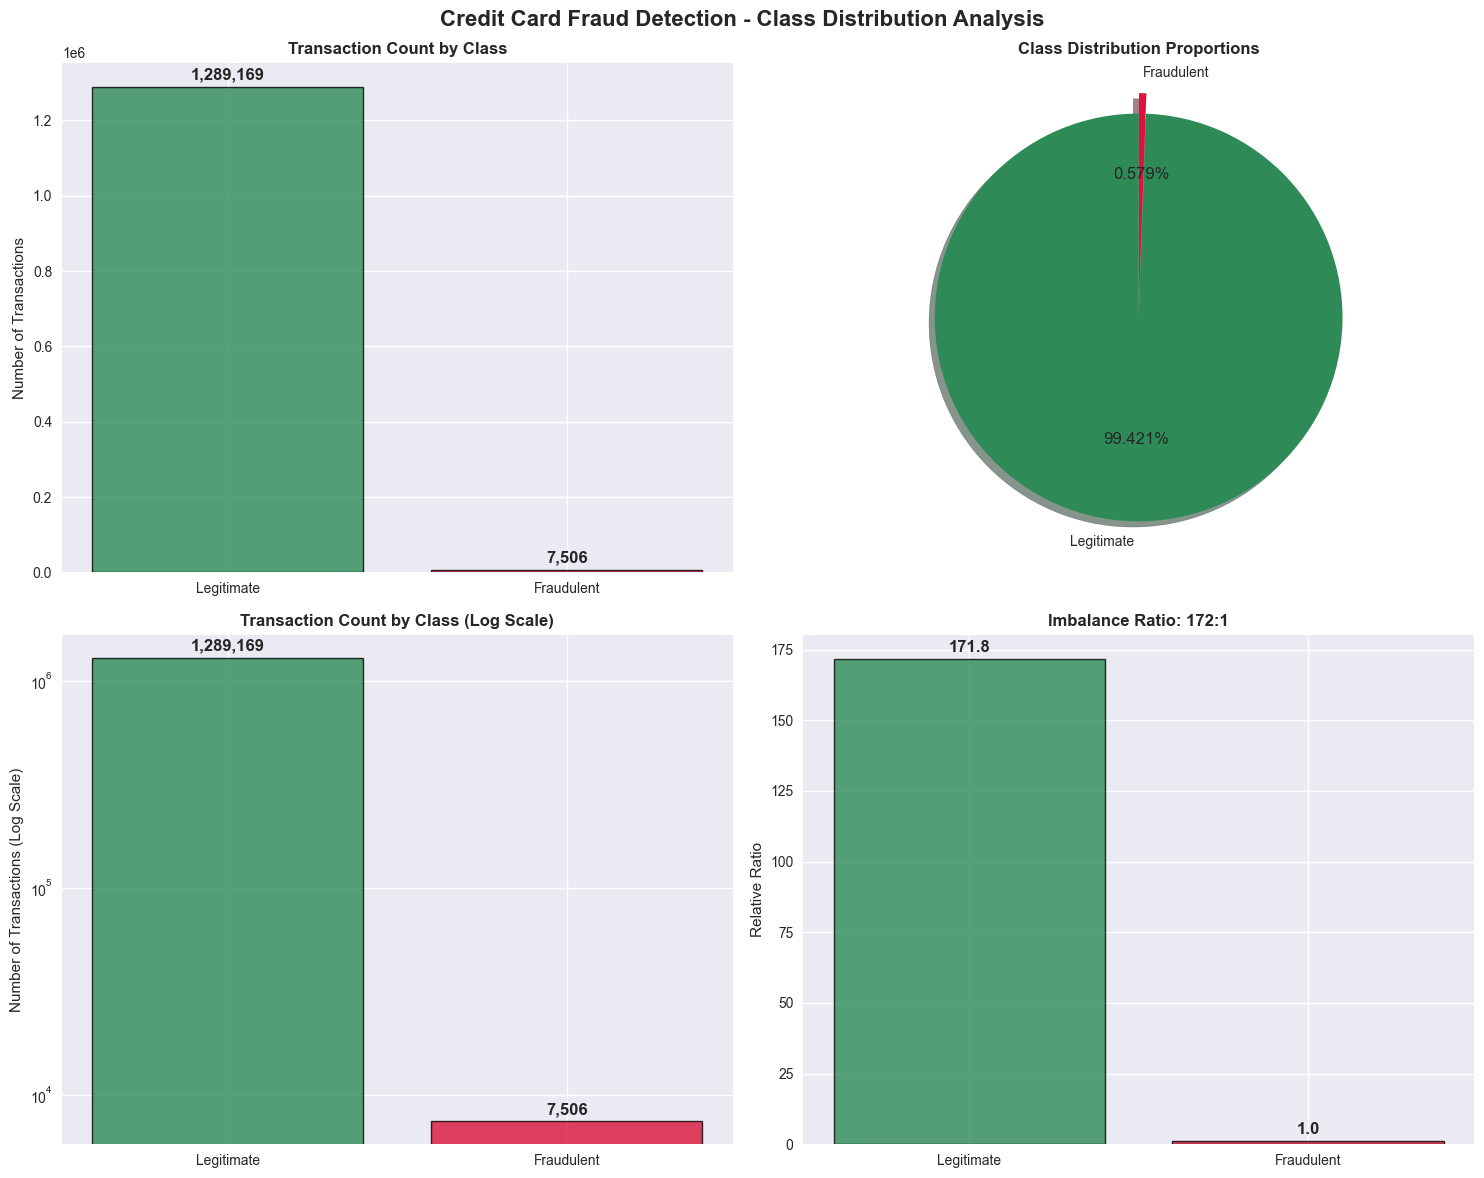


Key Statistics Summary:
Total Transactions: 1,296,675
Legitimate Rate: 99.421%
Fraud Rate: 0.579%
Imbalance Ratio: 171.8:1
Severity Level: Severe


In [15]:
# Create comprehensive class distribution visualizations
if class_distribution:
    # Set up the plotting area
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Credit Card Fraud Detection - Class Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 1. Bar plot of class counts
    ax1 = axes[0, 0]
    class_labels = ['Legitimate', 'Fraudulent']
    class_counts_list = [class_distribution['legitimate_count'], class_distribution['fraud_count']]
    colors = ['#2E8B57', '#DC143C']  # Sea green for legit, crimson for fraud
    
    bars = ax1.bar(class_labels, class_counts_list, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax1.set_title('Transaction Count by Class', fontweight='bold')
    ax1.set_ylabel('Number of Transactions')
    
    # Add value labels on bars
    for bar, count in zip(bars, class_counts_list):
        height = bar.get_height()
        ax1.annotate(f'{count:,}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontweight='bold')
    
    # 2. Pie chart showing proportions
    ax2 = axes[0, 1]
    sizes = [class_distribution['legitimate_count'], class_distribution['fraud_count']]
    explode = (0, 0.1)  # Explode fraud slice
    
    wedges, texts, autotexts = ax2.pie(sizes, labels=class_labels, colors=colors, autopct='%1.3f%%',
                                      explode=explode, shadow=True, startangle=90)
    ax2.set_title('Class Distribution Proportions', fontweight='bold')
    
    # 3. Log scale bar plot to show imbalance more clearly
    ax3 = axes[1, 0]
    bars_log = ax3.bar(class_labels, class_counts_list, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax3.set_yscale('log')
    ax3.set_title('Transaction Count by Class (Log Scale)', fontweight='bold')
    ax3.set_ylabel('Number of Transactions (Log Scale)')
    
    # Add value labels on log bars
    for bar, count in zip(bars_log, class_counts_list):
        height = bar.get_height()
        ax3.annotate(f'{count:,}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontweight='bold')
    
    # 4. Imbalance ratio visualization
    ax4 = axes[1, 1]
    ratio_data = [class_distribution['imbalance_ratio'], 1]
    ratio_labels = ['Legitimate', 'Fraudulent']
    
    bars_ratio = ax4.bar(ratio_labels, ratio_data, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax4.set_title(f'Imbalance Ratio: {class_distribution["imbalance_ratio"]:.0f}:1', fontweight='bold')
    ax4.set_ylabel('Relative Ratio')
    
    # Add ratio labels
    for bar, ratio in zip(bars_ratio, ratio_data):
        height = bar.get_height()
        ax4.annotate(f'{ratio:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Additional statistics box
    print("\nKey Statistics Summary:")
    print("=" * 40)
    print(f"Total Transactions: {class_distribution['total_count']:,}")
    print(f"Legitimate Rate: {100 - class_distribution['fraud_percentage']:.3f}%")
    print(f"Fraud Rate: {class_distribution['fraud_percentage']:.3f}%")
    print(f"Imbalance Ratio: {class_distribution['imbalance_ratio']:.1f}:1")
    print(f"Severity Level: {class_distribution['severity']}")
else:
    print("Cannot create visualizations - class distribution analysis failed")

### Final Summary & Completion Status

Overall summary of the data loading and understanding phase completion.

In [16]:
# Final completion summary
print("Data Loading & Understanding - Phase Completion Summary")
print("=" * 70)

print("COMPLETED OBJECTIVES:")
print("   Memory-optimized data loading infrastructure implemented")
print("   Comprehensive data quality assessment completed")
print("   Class distribution and imbalance analysis finished")
print("   Feature classification and cardinality analysis done")
print("   Initial pattern discovery and strategic insights generated")

print("\nKEY METRICS ACHIEVED:")
print(f"   Dataset successfully loaded: {train_loading_stats['rows_loaded']:,} records")
print(f"   Memory optimization: {optimization_comparison['memory_savings_percent']:.1f}% reduction")
print(f"   Class imbalance identified: {class_distribution['imbalance_ratio']:.0f}:1 ratio")
print(f"   Features analyzed: {len(train_df.columns)} total features")

print("\nREADY FOR NEXT PHASE:")
print("   Target: Begin Exploratory Data Analysis (EDA)")
print("   Focus: Multi-dimensional fraud pattern discovery")
print("   Infrastructure: Optimized and validated")
print("   Foundation: Comprehensive understanding established")

print("\nARTIFACTS CREATED:")
print("   Optimized dataset loading functions")
print("   Comprehensive feature documentation")
print("   Data quality validation framework")
print("   Strategic insights for modeling")

print("\n" + "=" * 70)
print("PHASE 1 STATUS: COMPLETED SUCCESSFULLY")
print("COMPLETION DATE:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print("NEXT PHASE: Exploratory Data Analysis (EDA)")
print("=" * 70)

Data Loading & Understanding - Phase Completion Summary
COMPLETED OBJECTIVES:
   Memory-optimized data loading infrastructure implemented
   Comprehensive data quality assessment completed
   Class distribution and imbalance analysis finished
   Feature classification and cardinality analysis done
   Initial pattern discovery and strategic insights generated

KEY METRICS ACHIEVED:
   Dataset successfully loaded: 1,296,675 records
   Memory optimization: 42.7% reduction
   Class imbalance identified: 172:1 ratio
   Features analyzed: 23 total features

READY FOR NEXT PHASE:
   Target: Begin Exploratory Data Analysis (EDA)
   Focus: Multi-dimensional fraud pattern discovery
   Infrastructure: Optimized and validated
   Foundation: Comprehensive understanding established

ARTIFACTS CREATED:
   Optimized dataset loading functions
   Comprehensive feature documentation
   Data quality validation framework
   Strategic insights for modeling

PHASE 1 STATUS: COMPLETED SUCCESSFULLY
COMPLETION 